# Reading Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def  Data(train_path):
    classes, class_paths = zip(*[(label, os.path.join(train_path, label, image))
                                for label in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, label))
                                for image in os.listdir(os.path.join(train_path, label))])
    Data = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return Data

In [3]:
df = Data('/kaggle/input/chest-x-ray-images-pneumonia-augmented/All_Data')

In [4]:
df.head()

,Class Path,Class
0,/kaggle/input/chest-x-ray-images-pneumonia-aug...,PNEUMONIA
1,/kaggle/input/chest-x-ray-images-pneumonia-aug...,PNEUMONIA
2,/kaggle/input/chest-x-ray-images-pneumonia-aug...,PNEUMONIA
3,/kaggle/input/chest-x-ray-images-pneumonia-aug...,PNEUMONIA
4,/kaggle/input/chest-x-ray-images-pneumonia-aug...,PNEUMONIA


In [5]:
df.tail()

,Class Path,Class
9993,/kaggle/input/chest-x-ray-images-pneumonia-aug...,NORMAL
9994,/kaggle/input/chest-x-ray-images-pneumonia-aug...,NORMAL
9995,/kaggle/input/chest-x-ray-images-pneumonia-aug...,NORMAL
9996,/kaggle/input/chest-x-ray-images-pneumonia-aug...,NORMAL
9997,/kaggle/input/chest-x-ray-images-pneumonia-aug...,NORMAL


## Splitting Data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= df['Class'])

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= False, random_state= 42)

In [8]:
len(train_df), len(valid_df), len(test_df)

(7998, 1000, 1000)

## Create image data generator

In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-19 00:46:10.380524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747615570.586343      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747615570.644515      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# EfficientNetB3 expects (300, 300) input size
img_size = (300, 300)
batch_size = 16
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended test batch size calculation
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Preprocessing function for grayscale to RGB + EfficientNet preprocess
def preprocess_grayscale_to_rgb(img):
    return effnet_preprocess(img)

# ImageDataGenerators
tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_grayscale_to_rgb,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(
    preprocessing_function=preprocess_grayscale_to_rgb
)

# Train generator
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation generator
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Test generator
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 7998 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


## Show sample from train data

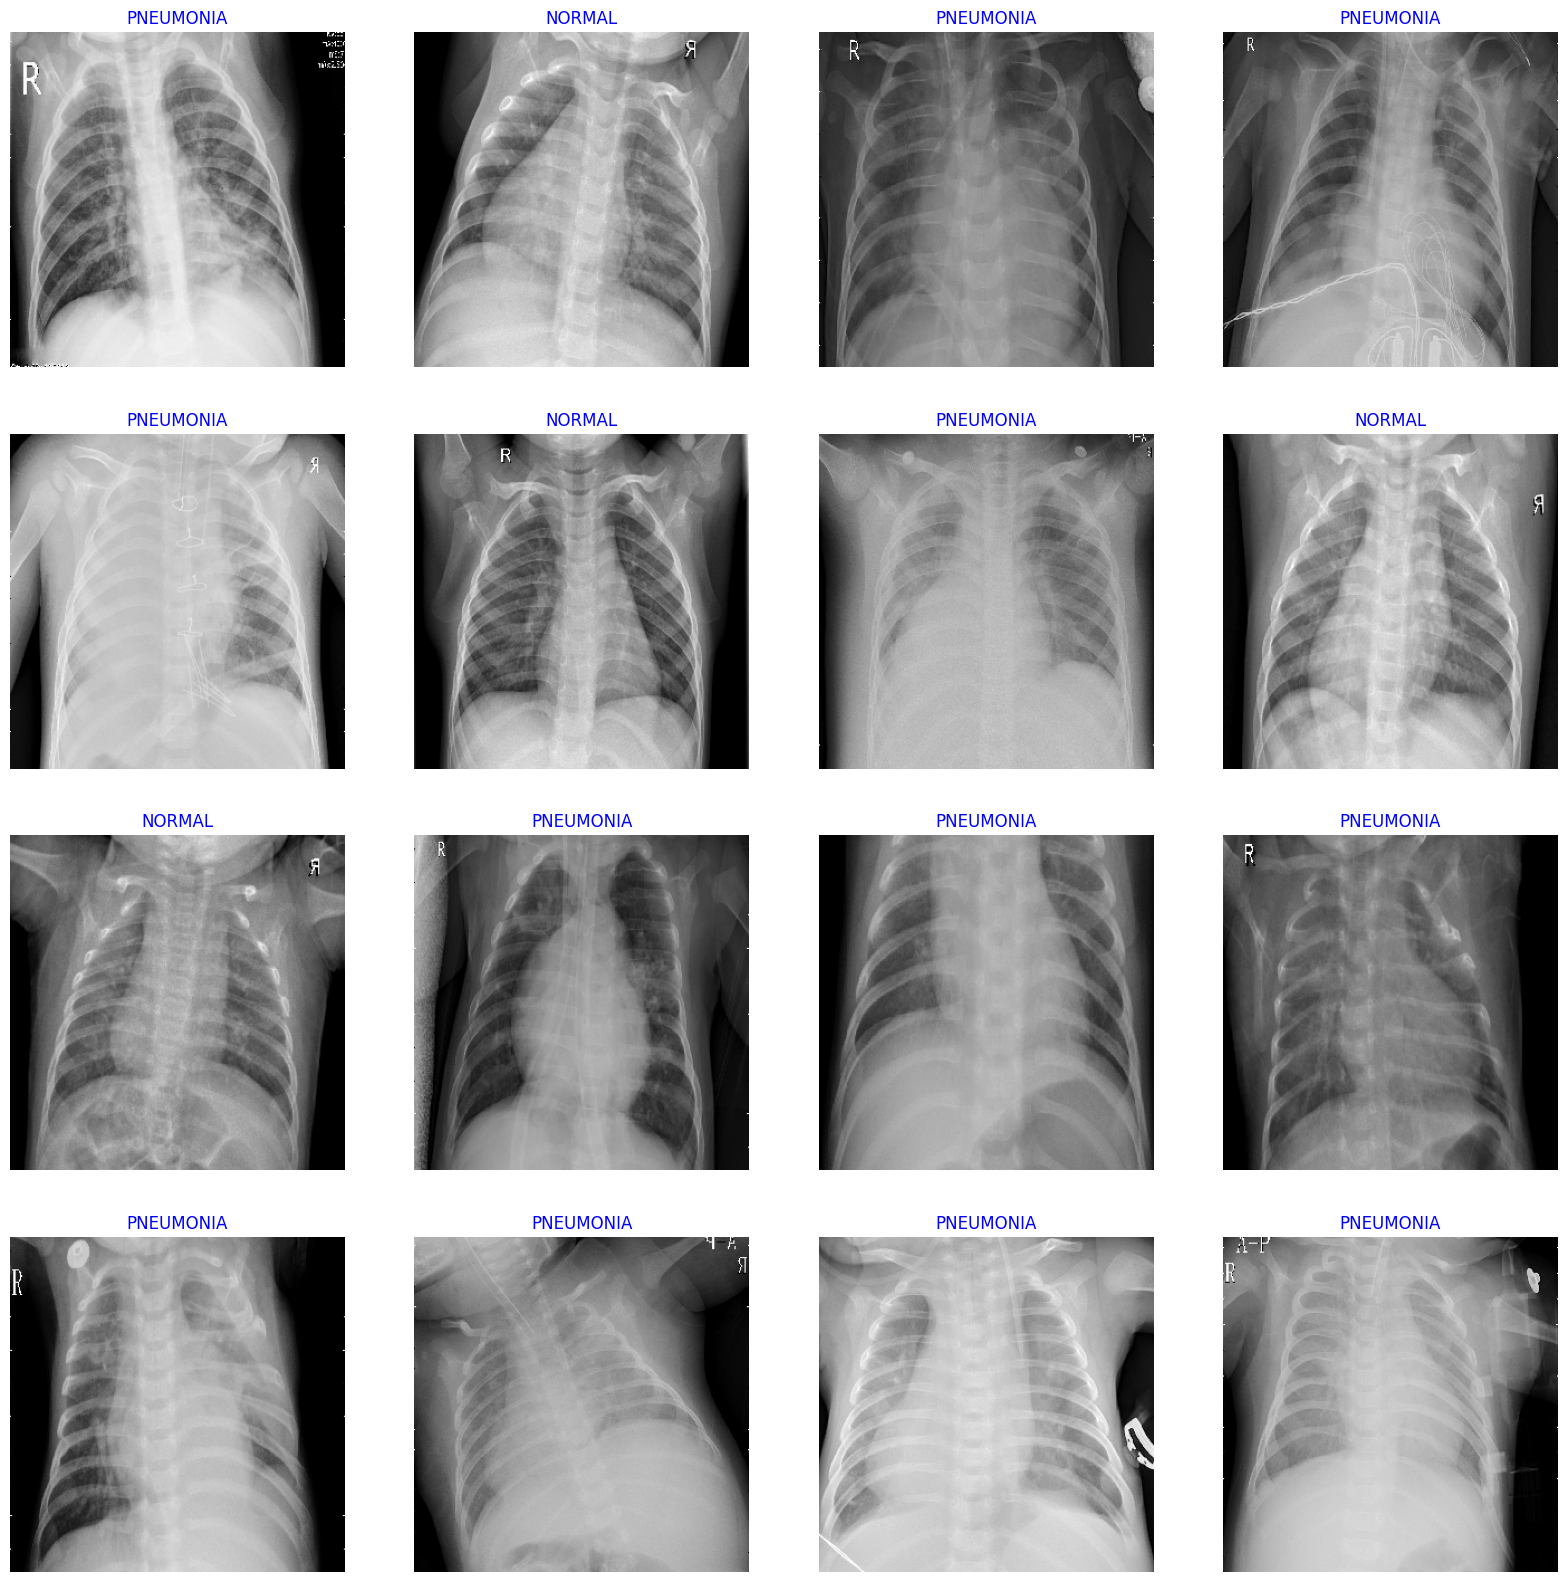

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [14]:
# Create Model Structure
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.3, seed= 42),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

I0000 00:00:1747615729.304619      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
batch_size = 16
epochs = 10

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= True)

Epoch 1/10


I0000 00:00:1747615824.488021     106 service.cc:148] XLA service 0x7f974c002090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747615824.488927     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747615831.014979     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747615843.660241     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615843.853781     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615844.379236     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615844.5957

 56/500 ━━━━━━━━━━━━━━━━━━━━ 1:40 226ms/step - accuracy: 0.7703 - loss: 14.4950

E0000 00:00:1747615902.633639     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615902.827260     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615903.359797     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615903.576305     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747615903.978673     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 369ms/step - accuracy: 0.7240 - loss: 8.0896 - val_accuracy: 0.5200 - val_loss: 3.7259
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 213ms/step - accuracy: 0.5978 - loss: 3.1520 - val_accuracy: 0.9210 - val_loss: 1.8934
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 215ms/step - accuracy: 0.8575 - loss: 1.5505 - val_accuracy: 0.9400 - val_loss: 1.0180
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 211ms/step - accuracy: 0.8632 - loss: 0.8499 - val_accuracy: 0.9630 - val_loss: 0.5554
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.8938 - loss: 0.5787 - val_accuracy: 0.9720 - val_loss: 0.4086
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.9522 - loss: 0.4486 - val_accuracy: 0.9760 - val_loss: 0.3367
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 106s 212ms/step - accuracy: 0.9497 - loss: 0.4030 - val_accuracy: 0.9790 - val_loss: 0.2957
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 214ms/step - accuracy: 0.9597 - loss: 0.36

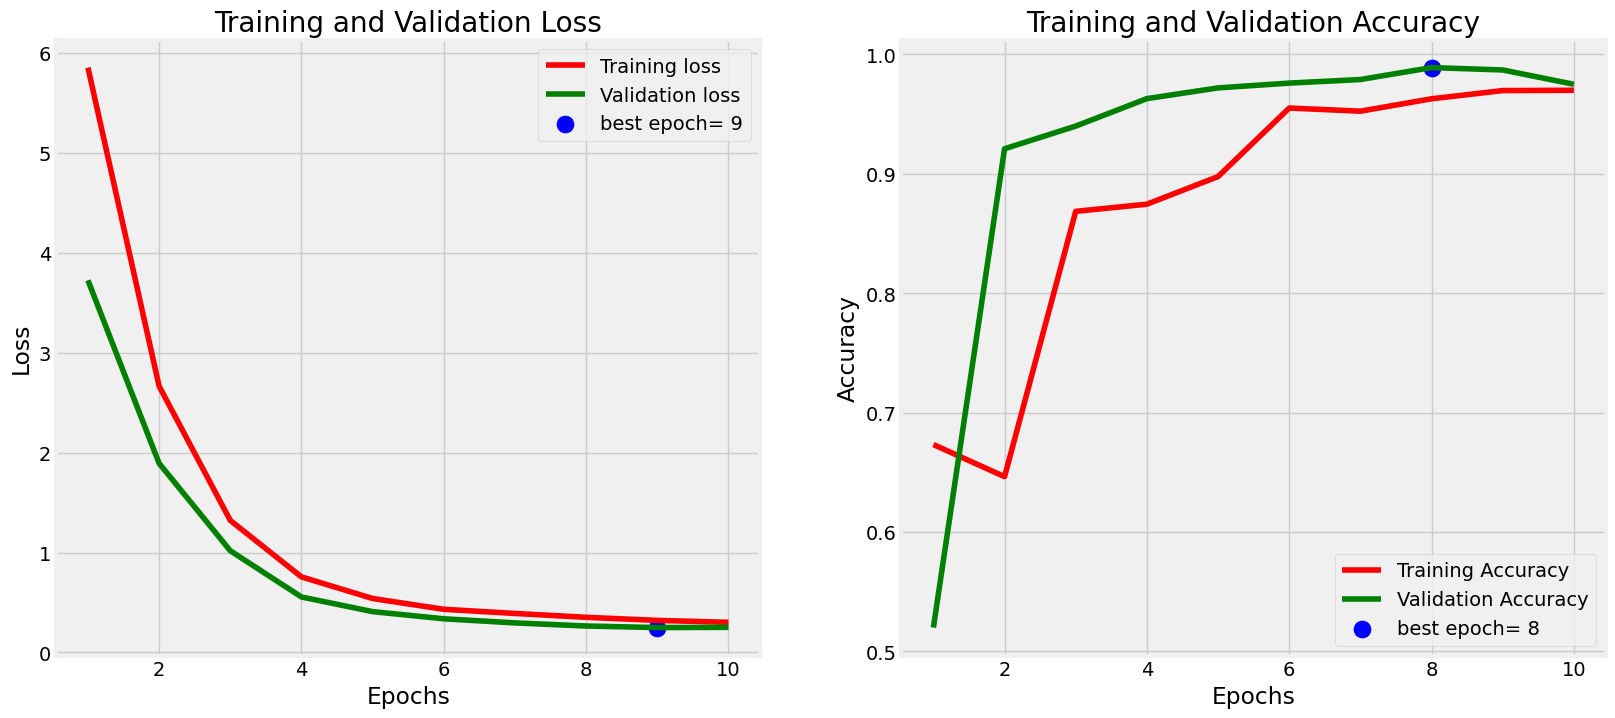

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9744 - loss: 0.2552
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9818 - loss: 0.2377
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.9760 - loss: 0.5321
Train Loss:  0.23675695061683655
Train Accuracy:  0.981249988079071
--------------------
Validation Loss:  0.2571040987968445
Validation Accuracy:  0.971875011920929
--------------------
Test Loss:  0.5356040596961975
Test Accuracy:  0.9750000238418579


In [19]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

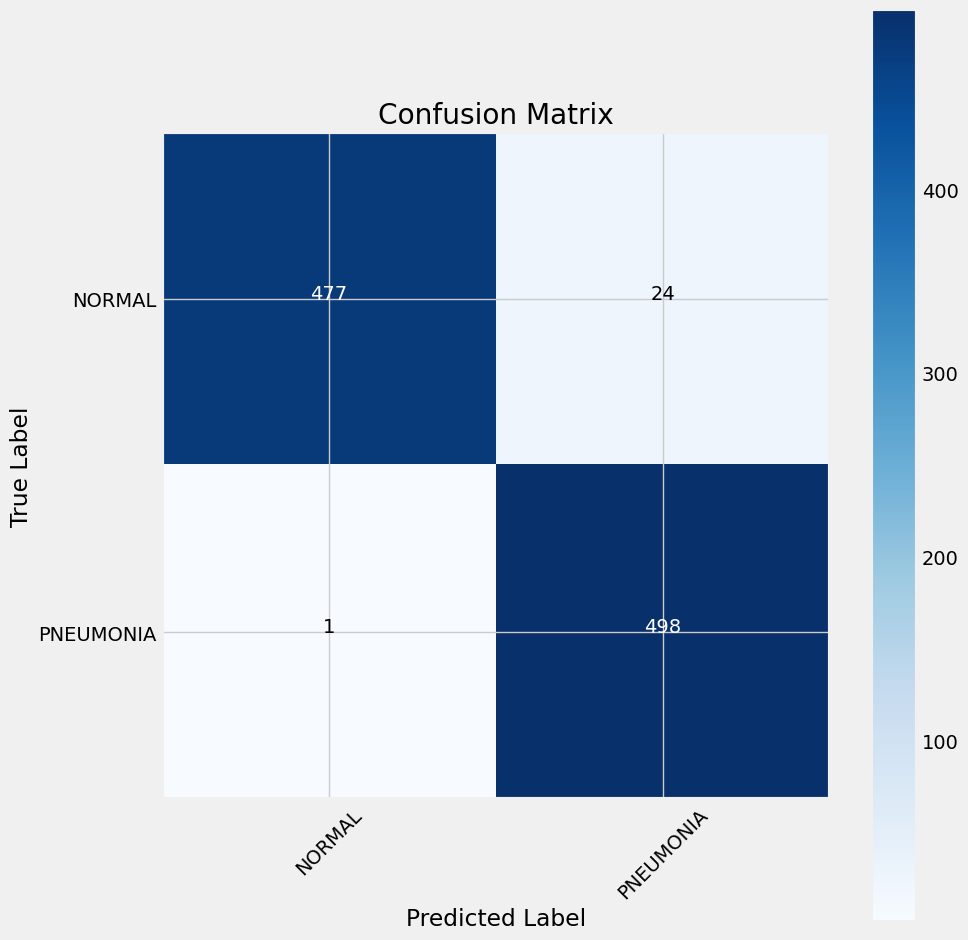

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97       501
   PNEUMONIA       0.95      1.00      0.98       499

    accuracy                           0.97      1000
   macro avg       0.98      0.98      0.97      1000
weighted avg       0.98      0.97      0.97      1000



In [23]:
model.save('keras_efficentnetb0_Chest_X-Ray.keras')

## Inference

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from PIL import Image
import numpy as np

# Load your model
model = load_model('/kaggle/working/keras_efficentnetb0_Chest_X-Ray.keras')

# Parameters
img_size = (300, 300)
classes = ['NORMAL', 'PNEUMONIA']

# Load and preprocess image function
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Ensure 3 channels
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = effnet_preprocess(img_array)    # Use EfficientNet preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

# Inference
image_path = '/kaggle/input/chest-x-ray-images-pneumonia-augmented/All_Data/PNEUMONIA/PNEUMONIA_original_person1071_bacteria_3005.jpeg_076c87bd-26c9-4071-9ba9-249ca6612ee0.jpeg'
img_array, original_img = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {classes[predicted_class[0]]}, Confidence: {predictions[0][predicted_class[0]]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted class: PNEUMONIA, Confidence: 0.9823
